# Given the stock information of at least the past 5 days of one particular company, try to predict the closing price of that company on a particular day

# Load libraries

In [405]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import root_mean_squared_error

# Load training set and process date to ensure it is parseable

In [406]:
# Load the dataset
data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\train_data.csv")
# Print the first few rows and the columns of the DataFrame
print("Columns in the DataFrame:", data.columns)
print(data.head())

# Convert 'Date' to datetime, handling errors
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Check for NaT values after conversion
if data['Date'].isnull().any():
    print("There are unparseable dates:")
    print(data[data['Date'].isnull()])

Columns in the DataFrame: Index(['Date', 'Close', 'Volume', 'Symbol', 'News - Positive Sentiment',
       'News - Negative Sentiment', 'News - New Products', 'News - Layoffs',
       'News - Analyst Comments', 'News - Stocks', 'News - Dividends',
       'News - Corporate Earnings', 'News - Mergers & Acquisitions',
       'News - Store Openings', 'News - Product Recalls',
       'News - Adverse Events', 'News - Personnel Changes',
       'News - Stock Rumors', 'GICS Sector', 'Headquarters Location',
       'Founded', 'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_4',
       'Close_lag_5', 'Day', 'Month', 'Weekday'],
      dtype='object')
         Date       Close   Volume Symbol  News - Positive Sentiment  \
0  2020-09-30  100.940002  1362200      A                       14.0   
1  2020-10-01  101.220001   723600      A                        0.0   
2  2020-10-02  100.010002   712200      A                        0.0   
3  2020-10-05  103.120003   803900      A                 

C:\Users\Admin\AppData\Local\Temp\ipykernel_26764\2789867827.py:2: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\train_data.csv")


# Define your company of interest and obtain its closing price for the days in training set (n>= 5)

In [407]:
# YOU CAN CHANGE THE COMPANY SYMBOL HERE
# to define the company of interest
company = 'MMM' 

# Filter data for the specific company
company_data = data[data['Symbol'] == company]

# Check if company is in dataset
if company_data.empty:
    raise ValueError(f"No data found for company: {company}")

# Set the 'Date' column as the index
company_data.set_index('Date', inplace=True)

# Ensure we have at least 5 days of data
if len(company_data) < 5:
    raise ValueError("Not enough data to predict. At least 5 days are required.")

# YOU CAN CHANGE HOW MANY DAYS YOU WANT TO TRAIN YOUR MODEL HERE
# train n days for modeling - we will use entire length of training set
train_n_days = company_data['Close']

# Ensure 'train_n_days' is not empty
if train_n_days.empty:
    raise ValueError("No closing price data available for modeling.")

# Perform Rolling-window Cross Validation

In [408]:
# Define rolling window parameters
n = len(train_n_days)
train_size = int(n * 0.8)
test_size = n - train_size
roll_window = 1


# library ExponentialSmoothing automatically finds optimal alpha, beta and gamma parameters but we still need to determine if parameters trend and seasonal are additive or multiplicative

In [409]:
# Define parameter combinations
param_combinations = [
    ('add', 'add'),
    ('add', 'mul'),
    ('mul', 'add'),
    ('mul', 'mul')
]

results = []

# Rolling window cross-validation
for start in range(0, test_size, roll_window):
    train = train_n_days.iloc[:train_size + start]
    test = train_n_days.iloc[train_size + start: train_size + start + roll_window]
    
    for trend, seasonal in param_combinations:
        try:
            model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=7) #weekly seasonality
            fit = model.fit()
            
            # Forecast the next value
            forecast = fit.forecast(roll_window)
            
            # Calculate RMSE
            rmse = root_mean_squared_error(test, forecast) 
            
            results.append({
                'trend': trend,
                'seasonal': seasonal,
                'start': start,
                'rmse': rmse,
            })
        except Exception as e:
            print(f"Error fitting model with trend={trend} and seasonal={seasonal}: {e}")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)

# Summarize results
summary = results_df.groupby(['trend', 'seasonal']).agg({'rmse': 'mean'}).reset_index()
print(summary)

# Find the row with the minimum RMSE
lowest_rmse_row = summary.loc[summary['rmse'].idxmin()]

# Extract the trend and seasonal values
lowest_trend = lowest_rmse_row['trend']
lowest_seasonal = lowest_rmse_row['seasonal']

print(f"Lowest RMSE: {lowest_rmse_row['rmse']}")
print(f"Trend: {lowest_trend}, Seasonal: {lowest_seasonal}")

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(da

  trend seasonal      rmse
0   add      add  1.266823
1   add      mul  1.267996
2   mul      add  1.267100
3   mul      mul  1.267164
Lowest RMSE: 1.2668226851080036
Trend: add, Seasonal: add


c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Us

# Input the trend and seasonal, that gives the lowest RMSE found during cross validation, into Holt-Winter's model

In [410]:
# Fit the Holt-Winters model
model = ExponentialSmoothing(
    train_n_days,
    trend=lowest_trend,
    seasonal=lowest_seasonal,
    seasonal_periods=7
).fit()

print(model.summary())

c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Close   No. Observations:                  317
Model:             ExponentialSmoothing   SSE                           1437.737
Optimized:                         True   AIC                            501.280
Trend:                         Additive   BIC                            542.628
Seasonal:                      Additive   AICC                           502.481
Seasonal Periods:                     7   Date:                 Fri, 01 Nov 2024
Box-Cox:                          False   Time:                         12:07:24
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.9718336                alpha                 True
smoothing_trend          

# Visualise Holt-Winter's smoothed values and actual values and calculate in-sample RMSE and MAPE

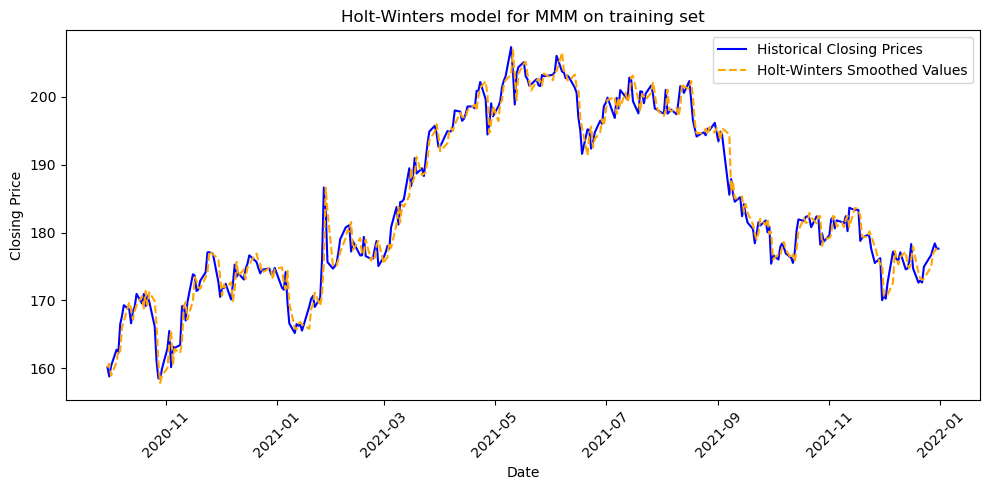

Predicted Closing Price for MMM on the next day: 178.15518978879842
RMSE between smoothed values and historical closing prices: 1.2668226851080036
MAPE between smoothed values and historical closing prices: 0.87%


In [411]:
# Prepare data for visualization
# CHANGE number of m days you want to see the historical closing prices if you did not train entire training set
historical_m_data = company_data['Close'][:]  
smoothed_values = model.fittedvalues

# Visualization
plt.figure(figsize=(10, 5))
plt.plot(historical_m_data.index, historical_m_data, label='Historical Closing Prices', color='blue')
plt.plot(smoothed_values.index, smoothed_values, label='Holt-Winters Smoothed Values', color='orange', linestyle='--')
plt.title(f'Holt-Winters model for {company} on training set')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the predicted closing price and this model's RMSE and MAPE
print(f'Predicted Closing Price for {company} on the next day: {forecast.iloc[0]}')
print(f"RMSE between smoothed values and historical closing prices: {lowest_rmse_row['rmse']}")
# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((train_n_days.values - smoothed_values.values) / train_n_days.values)) * 100
print(f'MAPE between smoothed values and historical closing prices: {mape:.2f}%')


# Forecast using model above and compare against data in TEST set

In [412]:
# Load the dataset
test_data = pd.read_csv(r"C:\Users\Admin\IT1244-Stock-Market\test_data.csv")
# Print the first few rows and the columns of the DataFrame
print("Columns in the DataFrame:", test_data.columns)
print(test_data.head())

# Convert 'Date' to datetime, handling errors
test_data['Date'] = pd.to_datetime(test_data['Date'], errors='coerce')

# Check for NaT values after conversion
if test_data['Date'].isnull().any():
    print("There are unparseable dates:")
    print(test_data[test_data['Date'].isnull()])

Columns in the DataFrame: Index(['Date', 'Close', 'Volume', 'Symbol', 'News - Positive Sentiment',
       'News - Negative Sentiment', 'News - New Products', 'News - Layoffs',
       'News - Analyst Comments', 'News - Stocks', 'News - Dividends',
       'News - Corporate Earnings', 'News - Mergers & Acquisitions',
       'News - Store Openings', 'News - Product Recalls',
       'News - Adverse Events', 'News - Personnel Changes',
       'News - Stock Rumors', 'GICS Sector', 'Headquarters Location',
       'Founded', 'Close_lag_1', 'Close_lag_2', 'Close_lag_3', 'Close_lag_4',
       'Close_lag_5', 'Day', 'Month', 'Weekday'],
      dtype='object')
         Date       Close   Volume Symbol  News - Positive Sentiment  \
0  2022-01-03  156.479996  1606300      A                        0.0   
1  2022-01-04  151.190002  2234000      A                        0.0   
2  2022-01-05  148.600006  2370500      A                        0.0   
3  2022-01-06  149.119995  2298300      A                 

# Make forecast, plot against actual values and calculate the out-of-sample RMSE and MAPE

Date
2022-01-03    177.746721
2022-01-04    178.288537
2022-01-05    178.343158
2022-01-06    178.583250
2022-01-07    178.268219
                 ...    
2022-06-24    184.192707
2022-06-27    184.734523
2022-06-28    184.789145
2022-06-29    185.029236
2022-06-30    184.714205
Length: 124, dtype: float64


c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Admin\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


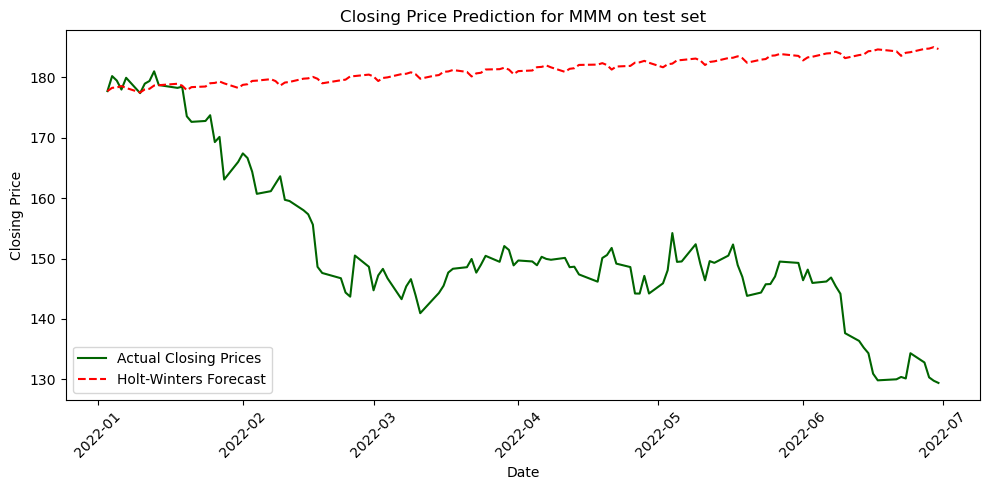

Predicted Closing Price for MMM on the next day: 177.74672104906853
RMSE between forecast values and actual closing prices: 32.82129716061761
MAPE between forecast values and actual closing prices: 16.28%


In [413]:
# YOU CAN CHANGE THE COMPANY SYMBOL HERE
# to define the company of interest
test_company ='MMM'

# Filter data for the specific company
test_company_data = test_data[test_data['Symbol'] == test_company]

# Ensure company is in the dataset
if test_company_data.empty:
    raise ValueError(f"No data found for company: {test_company}")

# Set the 'Date' column as the index
test_company_data.set_index('Date', inplace=True)

# Forecast target company's closing price for the length of test set
forecast = model.forecast(steps=len(test_company_data))

# Prepare data for visualization
# CHANGE number of m days you want to see the historical closing prices if you did not choose entire test set
test_historical_m_data = test_company_data['Close']

# Align predicted values with the test data index
forecast.index = test_historical_m_data.index

# Print the predicted values
print(forecast)

# Calcualte RMSE between actual values and smoothed values
test_rmse = root_mean_squared_error(forecast.values, test_historical_m_data.values)

# Calculate MAPE
test_mape = np.mean(np.abs((forecast.values - test_historical_m_data.values) / forecast.values)) * 100


# Visualization
plt.figure(figsize=(10, 5))
plt.plot(test_historical_m_data.index, test_historical_m_data, label='Actual Closing Prices', color='darkgreen')
plt.plot(forecast.index, forecast, label='Holt-Winters Forecast', color='red', linestyle='--')
plt.title(f'Closing Price Prediction for {test_company} on test set')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Output the predicted closing price and print its performance metrics
print(f'Predicted Closing Price for {test_company} on the next day: {forecast.iloc[0]}')
print(f"RMSE between forecast values and actual closing prices: {test_rmse}")
print(f'MAPE between forecast values and actual closing prices: {test_mape:.2f}%')

# Combine both plots to visualise how the model fitted the training data and forecasted against the test data

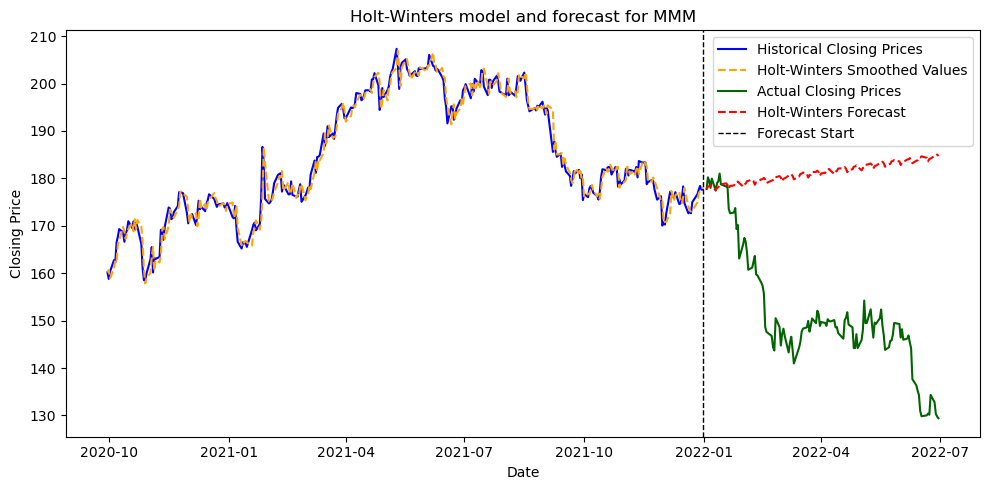

In [414]:
plt.figure(figsize=(10, 5))
plt.plot(historical_m_data.index, historical_m_data, label='Historical Closing Prices', color='blue')
plt.plot(smoothed_values.index, smoothed_values, label='Holt-Winters Smoothed Values', color='orange', linestyle='--')
plt.title(f'Holt-Winters model and forecast for {company}')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.plot(test_historical_m_data.index, test_historical_m_data, label='Actual Closing Prices', color='darkgreen')
plt.plot(forecast.index, forecast, label='Holt-Winters Forecast', color='red', linestyle='--')
plt.axvline(x=historical_m_data.index[-1], color='black', linewidth=1, linestyle='--', label='Forecast Start')
plt.legend()
plt.tight_layout()
plt.show()

In [415]:
hw_mape_dict = {'MMM':16.28, 'XOM':25.77, 'SHW':30.29, 'AMZN':16.57, 'PG':9.48, 'JNJ':2.15, 'JPM':20.02, 'AAPL':15.41, 'GOOGL':18.82, 'NEE':20.24, 'AMT':18.13}

hw_mape_mean = sum(hw_mape_dict.values()) / len(hw_mape_dict.values())  
print("Mean of MAPE values:", hw_mape_mean)

Mean of MAPE values: 17.56
